In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
import random

# ---------- Data ----------
transform_basic = transforms.ToTensor()

# Contrastive augmentations, to be experimented with
transform_simclr = transforms.Compose([
    transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees = 30), # 6 flipped completely is 9 so don't rotate too much.
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor()
])

'''
#other things tried
transform_simclr = transforms.Compose([
    #transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=5),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    #transforms.RandomErasing(p=0.3, scale=(0.02, 0.15)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

'''


'\n\ntransform_simclr = transforms.Compose([\n    #transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0)),\n    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=5),\n    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),\n    #transforms.RandomErasing(p=0.3, scale=(0.02, 0.15)),\n    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),\n    transforms.ToTensor(),\n    transforms.Normalize((0.5,), (0.5,)),\n])\n\n'

In [ ]:

#define contrastive dataset
class ContrastiveMNIST(Dataset):
    def __init__(self, train=True):
        self.dataset = datasets.MNIST(root="./data", train=train, download=True)
        self.transform = transform_simclr

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        x1 = self.transform(img)
        x2 = self.transform(img)
        return x1, x2

    def __len__(self):
        return len(self.dataset)




In [ ]:


# ---------- Model ----------
class SmallCNN(nn.Module):
    def __init__(self, projection_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
        )
        self.projector = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        return F.normalize(z, dim=1)

#define contrastive loss function as in report
def contrastive_loss(z, temperature=0.5):
    z = F.normalize(z, dim=1)
    sim = torch.matmul(z, z.T) / temperature
    mask = torch.eye(sim.size(0), dtype=torch.bool, device=z.device)
    sim.masked_fill_(mask, float('-inf'))
    N = z.size(0)//2
    positives = torch.cat([torch.arange(N, 2*N), torch.arange(N)], dim=0).to(z.device)
    numerator = sim[torch.arange(2*N), positives]
    loss = -numerator + torch.logsumexp(sim, dim=1)
    return loss.mean()





In [ ]:

# ---------- 1. Self-supervised pretraining ----------
# Check if GPU is available // use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#device = "cpu"
batch_size = 128
epochs_ssl = 8
temperature = 0.3

ssl_data = ContrastiveMNIST(train=True)
ssl_loader = DataLoader(ssl_data, batch_size=batch_size, shuffle=True)

ssl_model = SmallCNN().to(device)
optimizer = torch.optim.Adam(ssl_model.parameters(), lr=1e-3)

ssl_losses = []

#train
for epoch in range(epochs_ssl):
    total_loss = 0
    for x1, x2 in ssl_loader:
        z1, z2 = ssl_model(x1), ssl_model(x2)
        z = torch.cat([z1, z2], dim=0)
        loss = contrastive_loss(z, temperature)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[SSL] Epoch {epoch+1}/{epochs_ssl}, loss={total_loss/len(ssl_loader):.4f}")
    #store loss to list for plotting later
    ssl_losses.append(total_loss/len(ssl_loader))


# Freeze encoder for linear probing
for p in ssl_model.encoder.parameters():
    p.requires_grad = False




Using device: cpu
[SSL] Epoch 1/8, loss=3.1817
[SSL] Epoch 2/8, loss=2.8324
[SSL] Epoch 3/8, loss=2.7637
[SSL] Epoch 4/8, loss=2.7261
[SSL] Epoch 5/8, loss=2.7021
[SSL] Epoch 6/8, loss=2.6822
[SSL] Epoch 7/8, loss=2.6701
[SSL] Epoch 8/8, loss=2.6569


In [ ]:


# ---------- 2. Linear probe on small labeled subset ----------
# this is the downstream task
train_full = datasets.MNIST("./data", train=True, transform=transform_basic, download=True)
num_samples = len(train_full)
subset_size = int(0.05 * num_samples)  # we pretend here that only 5% labeled
subset_indices = random.sample(range(num_samples), subset_size)
train_subset = Subset(train_full, subset_indices)
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)

test_data = datasets.MNIST("./data", train=False, transform=transform_basic)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

linear = nn.Linear(128, 10).to(device)
optimizer = torch.optim.Adam(linear.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

ssl_label_losses = []
ssl_label_accuracies = []

def evaluate(model, classifier, loader):
    model.eval(); classifier.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            #same encoder
            h = model.encoder(x)
            logits = classifier(h)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

#train and evaluate linear probe
for epoch in range(15):
    linear.train()
    total_loss = 0
    for x, y in train_loader:
        with torch.no_grad():
            h = ssl_model.encoder(x)
        logits = linear(h)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    acc = evaluate(ssl_model, linear, test_loader)
    print(f"[Linear probe] Epoch {epoch+1}: loss={total_loss/len(train_loader):.4f}, acc={acc*100:.2f}%")
    ssl_label_losses.append(total_loss/len(train_loader))
    ssl_label_accuracies.append(acc)




[Linear probe] Epoch 1: loss=2.1184, acc=55.79%
[Linear probe] Epoch 2: loss=1.5823, acc=81.33%
[Linear probe] Epoch 3: loss=1.2201, acc=87.76%
[Linear probe] Epoch 4: loss=0.9787, acc=89.93%
[Linear probe] Epoch 5: loss=0.8122, acc=91.38%
[Linear probe] Epoch 6: loss=0.6967, acc=92.16%
[Linear probe] Epoch 7: loss=0.6120, acc=92.80%
[Linear probe] Epoch 8: loss=0.5482, acc=93.06%
[Linear probe] Epoch 9: loss=0.4956, acc=93.36%
[Linear probe] Epoch 10: loss=0.4552, acc=93.67%
[Linear probe] Epoch 11: loss=0.4242, acc=93.87%
[Linear probe] Epoch 12: loss=0.3949, acc=94.04%
[Linear probe] Epoch 13: loss=0.3697, acc=94.31%
[Linear probe] Epoch 14: loss=0.3530, acc=94.33%
[Linear probe] Epoch 15: loss=0.3365, acc=94.59%


In [18]:

# ---------- 3. Baseline supervised training (same encoder) ----------
sup_model = SmallCNN().to(device)
classifier = nn.Linear(128, 10).to(device)

optimizer = torch.optim.Adam(list(sup_model.parameters()) + list(classifier.parameters()), lr=1e-3)

supervised_losses=[]
supervised_accuracies = []

for epoch in range(15):
    sup_model.train(); classifier.train()
    total_loss = 0
    for x, y in train_loader:
        h = sup_model.encoder(x)
        logits = classifier(h)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    acc = evaluate(sup_model, classifier, test_loader)
    print(f"[Supervised] Epoch {epoch+1}: loss={total_loss/len(train_loader):.4f}, acc={acc*100:.2f}%")
    supervised_losses.append(total_loss/len(train_loader))
    supervised_accuracies.append(acc)


[Supervised] Epoch 1: loss=1.5515, acc=80.43%
[Supervised] Epoch 2: loss=0.5276, acc=87.25%
[Supervised] Epoch 3: loss=0.3993, acc=89.19%
[Supervised] Epoch 4: loss=0.3171, acc=90.92%
[Supervised] Epoch 5: loss=0.2738, acc=91.48%
[Supervised] Epoch 6: loss=0.2410, acc=92.26%
[Supervised] Epoch 7: loss=0.2075, acc=93.38%
[Supervised] Epoch 8: loss=0.1806, acc=92.92%
[Supervised] Epoch 9: loss=0.1404, acc=93.56%
[Supervised] Epoch 10: loss=0.1107, acc=93.95%
[Supervised] Epoch 11: loss=0.0898, acc=94.65%
[Supervised] Epoch 12: loss=0.0796, acc=94.18%
[Supervised] Epoch 13: loss=0.0725, acc=94.96%
[Supervised] Epoch 14: loss=0.0490, acc=95.19%
[Supervised] Epoch 15: loss=0.0407, acc=95.38%


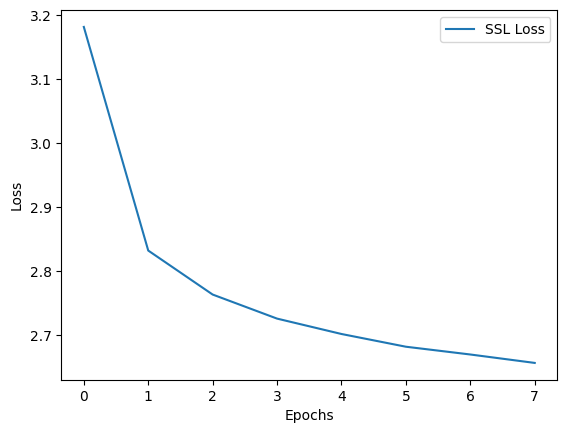

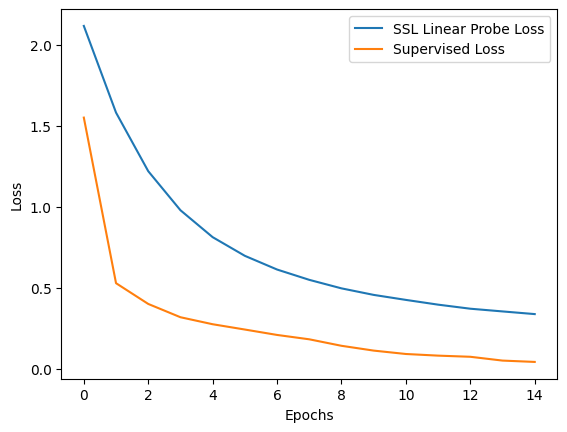

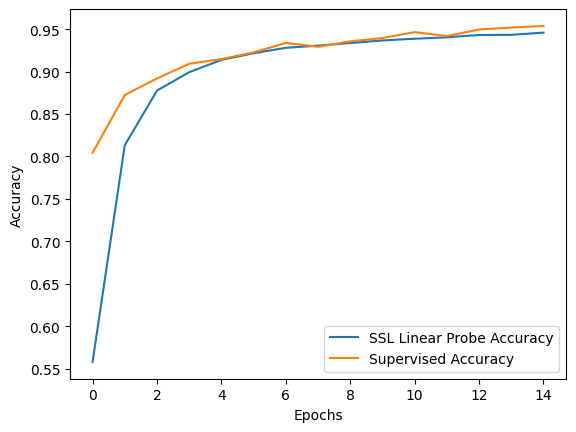

In [19]:
#plot all losses seperately, specifically ssl_losses, ssl_label_losses, supervised_losses
import matplotlib.pyplot as plt
plt.plot(ssl_losses, label='SSL Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.show()
plt.savefig('ssl_loss_t08.png')
plt.show()


plt.plot(ssl_label_losses, label='SSL Linear Probe Loss')
plt.plot(supervised_losses, label='Supervised Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.show()
plt.savefig('loss_comp_t08.png')
plt.show()

plt.plot(ssl_label_accuracies, label='SSL Linear Probe Accuracy')
plt.plot(supervised_accuracies, label='Supervised Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.show()
plt.savefig('acc_comp_t08_l_005.png')
plt.show()


In [20]:
#evaluete both models on test set and print accuracies
acc_ssl = evaluate(ssl_model, linear, test_loader)
acc_sup = evaluate(sup_model, classifier, test_loader)
print(f"Final SSL Linear Probe Test Accuracy: {acc_ssl*100:.2f}%")
print(f"Final Supervised Test Accuracy: {acc_sup*100:.2f}%")

Final SSL Linear Probe Test Accuracy: 94.59%
Final Supervised Test Accuracy: 95.38%
